# **CSCI 5501: DEEP LEARNING APPLICATION** - MINI PROJECT
### By - Het Patel (B00988337) & Akshat Gulati (B00863868)

# Melanoma Detection: End-to-End Segmentation and Classification with Deep Learning

This notebook presents an end-to-end deep learning pipeline for the automated analysis of skin lesion images, focusing on melanoma—the deadliest form of skin cancer. We implement and evaluate two critical tasks:

1. **Lesion Segmentation**: Identifying and outlining the exact region of a lesion in dermoscopic images using a U-Net architecture with a pre-trained ResNet34 encoder.
2. **Lesion Classification**: Determining whether the lesion is benign or malignant using an EfficientNet-based image classifier.

For segmentation, we train and validate on the ISIC 2018 dataset, which provides high-quality, pixel-level masks. For classification, we utilize the HAM10000 dataset, which contains thousands of dermoscopic images labeled as benign or malignant.

Our pipeline enables both **pixel-wise localization** and **whole-image diagnosis**, providing a comprehensive tool for supporting clinical decision-making in melanoma detection.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## PART-01: MELANOMA SKIN CANCER SEGMENTATION WITH U-NET USING RESNET34 ENCODER

In [ ]:
import os

base_path = '/content/drive/My Drive/Melanoma Detection'

train_img_dir = f"{base_path}/Training/images"
train_mask_dir = f"{base_path}/Training/masks"

val_img_dir = f"{base_path}/Validation/images"
val_mask_dir = f"{base_path}/Validation/masks"

# test_img_dir = f"{base_path}/Test/images"
test_mask_dir = f"{base_path}/Test/masks"

print("Train images:", len(os.listdir(train_img_dir)))
print("Train masks:", len(os.listdir(train_mask_dir)))

print("Validation images:", len(os.listdir(val_img_dir)))
print("Validation masks:", len(os.listdir(val_mask_dir)))

# print("Test images:", len(os.listdir(test_img_dir)))
print("Test masks:", len(os.listdir(test_mask_dir)))

Train images: 2595
Train masks: 2595
Validation images: 101
Validation masks: 101
Test masks: 1009


### Data Pairing and Preprocessing Utilities

This section prepares the ISIC 2018 segmentation data for model training and validation. It performs the following steps:

- **Directory Setup:**  
  Defines paths to the training and validation image and mask folders.

- **Pairing Utility:**  
  Implements a helper function to match each image with its corresponding segmentation mask based on filename stems, ensuring all data pairs are aligned and reporting any mismatches or missing files.

- **Preprocessing Function:**  
  Defines a function to read, resize, normalize, and binarize each image and mask to a consistent input size and format for the segmentation model.

- **Sanity Check:**  
  Verifies that the pairing and preprocessing steps work correctly by checking the first three image/mask pairs in both the training and validation splits and printing their shapes.

This setup ensures that every image is correctly paired with its mask and is ready for efficient and reliable data loading during model training.


In [ ]:
import os
import cv2
import numpy as np

# ─── 1) Define base directories ────────────────────────────────────────────────
base             = '/content/drive/My Drive/Melanoma Detection'
train_img_dir    = os.path.join(base, 'Training/images')
train_mask_dir   = os.path.join(base, 'Training/masks')
val_img_dir      = os.path.join(base, 'Validation/images')
val_mask_dir     = os.path.join(base, 'Validation/masks')

# ─── 2) Utility to match image & mask stems ────────────────────────────────────
def match_stems(img_dir, mask_dir, img_ext='.jpg', mask_suffix='_segmentation.png'):
    # 2.1 Gather and sort filenames
    imgs  = sorted(f for f in os.listdir(img_dir)  if f.lower().endswith(img_ext))
    masks = sorted(f for f in os.listdir(mask_dir) if f.lower().endswith(mask_suffix))
    # 2.2 Build stem sets
    img_stems  = {os.path.splitext(f)[0] for f in imgs}
    mask_stems = {os.path.splitext(f)[0].replace(mask_suffix.replace('.png',''), '') for f in masks}
    # 2.3 Intersection & orphans
    matched    = sorted(img_stems & mask_stems)
    only_imgs  = sorted(img_stems - mask_stems)
    only_masks = sorted(mask_stems - img_stems)
    # 2.4 Report
    print(f"[{os.path.basename(img_dir)}] images: {len(img_stems)}, masks: {len(mask_stems)}, matched: {len(matched)}")
    if only_imgs:
        print(f"  → {len(only_imgs)} images without mask, e.g. {only_imgs[:3]}")
    if only_masks:
        print(f"  → {len(only_masks)} masks without image, e.g. {only_masks[:3]}")
    # 2.5 Build aligned filename lists
    img_list  = [stem + img_ext      for stem in matched]
    mask_list = [stem + mask_suffix  for stem in matched]
    return matched, img_list, mask_list

# ─── 3) Match each split ───────────────────────────────────────────────────────
train_stems, train_imgs, train_masks = match_stems(train_img_dir, train_mask_dir)
val_stems,   val_imgs,   val_masks   = match_stems(val_img_dir,   val_mask_dir)

# ─── 4) Preprocessing function ────────────────────────────────────────────────
def load_and_preprocess(img_path, mask_path, size=(512,512)):
    # 4.1 Read image and mask
    img  = cv2.imread(img_path)                             # BGR or None
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)      # grayscale or None
    # 4.2 Convert & normalize
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img  = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    img  = img.astype(np.float32) / 255.0
    # 4.3 Resize mask & binarize
    mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.uint8)
    return img, mask

# ─── 5) Sanity‐check a few samples from each split ─────────────────────────────
splits = [
    ('Training',   train_img_dir,  train_imgs,  train_mask_dir, train_masks),
    ('Validation', val_img_dir,    val_imgs,    val_mask_dir,   val_masks),
]

for name, img_dir, imgs, mask_dir, masks in splits:
    print(f"\n— {name} split —")
    # Check first 3 samples
    for img_fn, mask_fn in zip(imgs[:3], masks[:3]):
        img_path  = os.path.join(img_dir,  img_fn)
        mask_path = os.path.join(mask_dir, mask_fn)
        # Existence
        print(f"{img_fn:<20} exists? {os.path.exists(img_path)} | "
              f"{mask_fn:<25} exists? {os.path.exists(mask_path)}")
        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            continue
        # Load & shape
        img  = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if img is None or mask is None:
            print("Failed to read one of the files.")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print("shapes:", img_rgb.shape, mask.shape)


[images] images: 2594, masks: 2594, matched: 2594
[images] images: 100, masks: 100, matched: 100

— Training split —
ISIC_0000000.jpg     exists? True | ISIC_0000000_segmentation.png exists? True
shapes: (767, 1022, 3) (767, 1022)
ISIC_0000001.jpg     exists? True | ISIC_0000001_segmentation.png exists? True
shapes: (767, 1022, 3) (767, 1022)
ISIC_0000003.jpg     exists? True | ISIC_0000003_segmentation.png exists? True
shapes: (767, 1022, 3) (767, 1022)

— Validation split —
ISIC_0012255.jpg     exists? True | ISIC_0012255_segmentation.png exists? True
shapes: (2848, 4288, 3) (2848, 4288)
ISIC_0012346.jpg     exists? True | ISIC_0012346_segmentation.png exists? True
shapes: (2000, 3008, 3) (2000, 3008)
ISIC_0012576.jpg     exists? True | ISIC_0012576_segmentation.png exists? True
shapes: (768, 1024, 3) (768, 1024)


### Custom PyTorch Dataset and DataLoader Construction

This cell builds the data pipeline needed for efficient training and validation of the segmentation model:

- **Custom Dataset Class (`SkinLesionDataset`):**
    - Loads and aligns each dermoscopic image with its corresponding segmentation mask using the matched filename stems.
    - Applies preprocessing to convert each image to an RGB float tensor and each mask to a binary tensor in the format required for training.
    - Supports optional transformations for data augmentation or normalization.

- **Dataset Instantiation:**
    - Creates separate dataset objects for training and validation splits, ensuring data is correctly partitioned and preprocessed.

- **PyTorch DataLoaders:**
    - Wraps each dataset in a DataLoader to enable batching, shuffling (for training), and efficient parallel data loading using multiple worker processes.
    - Improves GPU utilization and speeds up the model training loop.

- **Sanity Checks:**
    - Prints the dataset sizes and the shape of a sample batch to confirm that the data pipeline is working as expected.

This structure ensures that images and masks are consistently and efficiently provided to the model throughout the training and validation process.

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader

class SkinLesionDataset(Dataset):
    def __init__(self, img_dir, mask_dir, stems, transform=None):
        """
        img_dir   : path to images folder
        mask_dir  : path to masks folder
        stems     : list of filename stems (e.g. ['ISIC_000000', ...])
        transform : optional torchvision-like transform applied to (img, mask) pair
        """
        self.img_dir   = img_dir
        self.mask_dir  = mask_dir
        self.stems     = stems
        self.transform = transform

    def __len__(self):
        return len(self.stems)

    def __getitem__(self, idx):
        stem = self.stems[idx]
        img_path  = os.path.join(self.img_dir,  stem + '.jpg')
        mask_path = os.path.join(self.mask_dir, stem + '_segmentation.png')

        # load + preprocess numpy arrays
        img, mask = load_and_preprocess(img_path, mask_path, size=(512,512))

        # to torch.Tensor: img [H,W,3]→[3,H,W], mask [H,W]→[1,H,W]
        img_tensor  = torch.from_numpy(img).permute(2,0,1)
        mask_tensor = torch.from_numpy(mask)[None,...].float()

        if self.transform:
            img_tensor, mask_tensor = self.transform(img_tensor, mask_tensor)

        return img_tensor, mask_tensor

# ─── Instantiate datasets ─────────────────────────────────────────────────────
train_dataset = SkinLesionDataset(
    img_dir   = train_img_dir,
    mask_dir  = train_mask_dir,
    stems     = train_stems,
    transform = None
)

val_dataset = SkinLesionDataset(
    img_dir   = val_img_dir,
    mask_dir  = val_mask_dir,
    stems     = val_stems,
    transform = None
)

# ─── DataLoaders ────────────────────────────────────────────────────────────────
batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

# ─── Sanity prints ─────────────────────────────────────────────────────────────
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
imgs, masks = next(iter(train_loader))
print(f"One train batch: imgs {imgs.shape}, masks {masks.shape}")


Train dataset size: 2594
Validation dataset size: 100


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


One train batch: imgs torch.Size([8, 3, 512, 512]), masks torch.Size([8, 1, 512, 512])


### Visualizing Training Images and Masks

This cell displays a sample batch of images and their corresponding ground-truth segmentation masks from the training set.

- The top row shows the original dermoscopic images.
- The bottom row shows the associated binary masks, where white pixels indicate the lesion region.

This visualization step helps confirm that the image and mask pairs are correctly aligned and that preprocessing has been performed as expected.


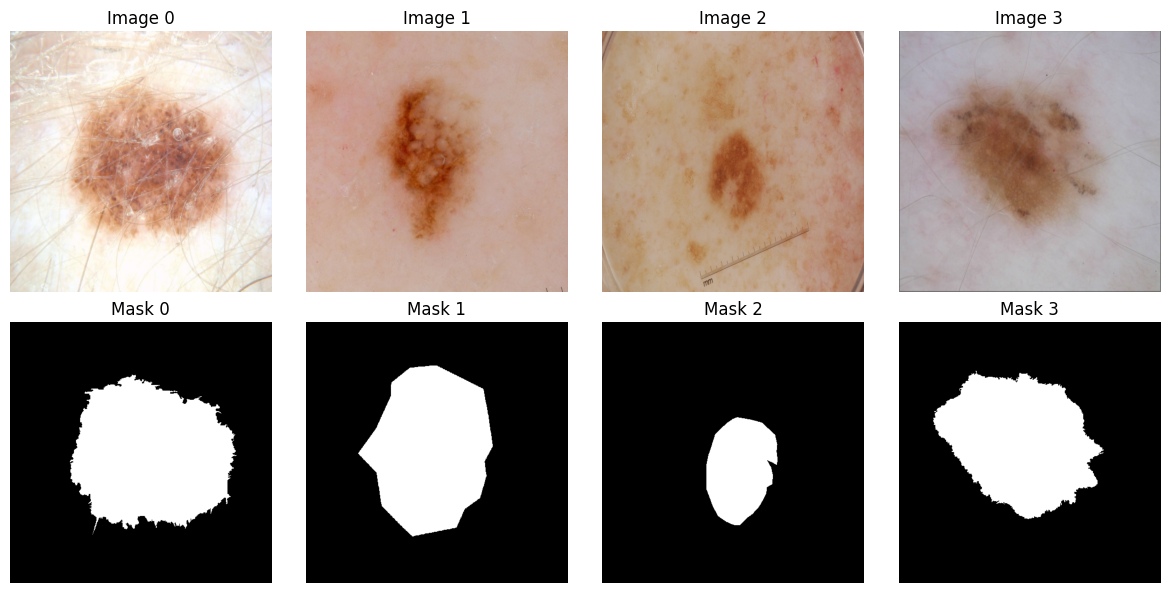

In [ ]:
import matplotlib.pyplot as plt

# grab one batch from the training loader
imgs, masks = next(iter(train_loader))

# show first 4 samples
n = min(4, imgs.size(0))
fig, axes = plt.subplots(2, n, figsize=(12, 6))
for i in range(n):
    # convert tensors to numpy arrays
    img_np  = imgs[i].permute(1, 2, 0).numpy()
    mask_np = masks[i][0].numpy()

    # display image
    axes[0, i].imshow(img_np)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Image {i}")

    # display mask
    axes[1, i].imshow(mask_np, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Mask {i}")

plt.tight_layout()
plt.show()


In [ ]:
!pip install segmentation-models-pytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.7 MB/s eta 0:00:00


### Training U-Net for Lesion Segmentation

This cell defines and trains a deep U-Net architecture for pixel-wise segmentation of skin lesions:

- **Model Architecture:**  
  Constructs a U-Net with a ResNet34 encoder pre-trained on ImageNet, which efficiently extracts features from dermoscopic images.

- **Loss Functions:**  
  Combines binary cross-entropy and Dice loss to optimize both pixel accuracy and overall mask overlap.

- **Training Loop:**  
  Iteratively trains the model for up to 50 epochs with early stopping based on validation loss improvement. After each epoch, the model's performance is evaluated on the validation set using loss and Dice coefficient metrics.

- **Checkpointing:**  
  The best-performing model (lowest validation loss) is automatically saved for future use.

This step enables the model to accurately segment the melanoma region in each image, providing precise localization for downstream analysis.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from tqdm.auto import tqdm

# 11.2 Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 11.3 Build U-Net
model = smp.Unet(
    encoder_name    = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels     = 3,
    classes         = 1,            # binary mask
).to(device)

# 11.4 Losses & metrics
bce_loss  = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode='binary')

def loss_fn(preds, masks):
    return bce_loss(preds, masks) + dice_loss(preds, masks)

# Dice coefficient metric
def dice_coeff(preds, masks, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(preds)
    preds_bin = (probs > thr).float()
    intersection = (preds_bin * masks).sum(dim=(1,2,3))
    union = preds_bin.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3))
    return ((2 * intersection + eps) / (union + eps)).mean().item()

# 11.5 Optimizer & scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

# 11.6 Training loop
num_epochs       = 50
best_val_loss    = float('inf')
epochs_no_improve = 0
early_stop_patience = 5  # stop if no improvement for 5 epochs

for epoch in range(1, num_epochs + 1):
    # — Train —
    model.train()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = loss_fn(preds, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # — Validate —
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            val_loss += loss_fn(preds, masks).item()
            val_dice += dice_coeff(preds, masks)
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)

    # — Scheduler step —
    scheduler.step(val_loss)

    # — Check for improvement & early stop logic —
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_unet.pth')
        checkpoint_msg = '✓ checkpointed'
    else:
        epochs_no_improve += 1
        checkpoint_msg = ''

    # — Log —
    print(
        f"Epoch {epoch}/{num_epochs} • "
        f"Train Loss: {train_loss:.4f} • "
        f"Val Loss:   {val_loss:.4f} • "
        f"Val Dice:   {val_dice:.4f} • "
        f"No Improve: {epochs_no_improve}/{early_stop_patience}{checkpoint_msg}"
    )

    # — Early stopping —
    if epochs_no_improve >= early_stop_patience:
        print(f"Stopping early after {epoch} epochs without improvement.")
        break


Using device: cuda


Epoch 1 [Train]:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1/50 • Train Loss: 0.5254 • Val Loss:   0.3745 • Val Dice:   0.8518 • No Improve: 0/5✓ checkpointed


Epoch 2 [Train]:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2/50 • Train Loss: 0.3077 • Val Loss:   0.3931 • Val Dice:   0.8470 • No Improve: 1/5


Epoch 3 [Train]:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3/50 • Train Loss: 0.2506 • Val Loss:   0.3424 • Val Dice:   0.8765 • No Improve: 0/5✓ checkpointed


Epoch 4 [Train]:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4/50 • Train Loss: 0.2180 • Val Loss:   0.3306 • Val Dice:   0.8751 • No Improve: 0/5✓ checkpointed


Epoch 5 [Train]:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5/50 • Train Loss: 0.1881 • Val Loss:   0.3133 • Val Dice:   0.8775 • No Improve: 0/5✓ checkpointed


Epoch 6 [Train]:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 6/50 • Train Loss: 0.1755 • Val Loss:   0.3785 • Val Dice:   0.8667 • No Improve: 1/5


Epoch 7 [Train]:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 7/50 • Train Loss: 0.1617 • Val Loss:   0.2959 • Val Dice:   0.8893 • No Improve: 0/5✓ checkpointed


Epoch 8 [Train]:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 8/50 • Train Loss: 0.1419 • Val Loss:   0.3292 • Val Dice:   0.8870 • No Improve: 1/5


Epoch 9 [Train]:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 9/50 • Train Loss: 0.1426 • Val Loss:   0.3230 • Val Dice:   0.8812 • No Improve: 2/5


Epoch 10 [Train]:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 10/50 • Train Loss: 0.1277 • Val Loss:   0.3333 • Val Dice:   0.8725 • No Improve: 3/5


Epoch 11 [Train]:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 11/50 • Train Loss: 0.1166 • Val Loss:   0.3578 • Val Dice:   0.8753 • No Improve: 4/5


Epoch 12 [Train]:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 12/50 • Train Loss: 0.0941 • Val Loss:   0.3480 • Val Dice:   0.8780 • No Improve: 5/5
Stopping early after 12 epochs without improvement.


In [ ]:
# ─── 1) Define Test directories ─────────────────────────────────────────────────
test_img_dir  = os.path.join(base, 'Test/images')
test_mask_dir = os.path.join(base, 'Test/masks')

# ─── 2) Match test stems ────────────────────────────────────────────────────────
test_stems, test_imgs, test_masks = match_stems(test_img_dir, test_mask_dir)

# ─── 3) Instantiate Test Dataset ───────────────────────────────────────────────
test_dataset = SkinLesionDataset(
    img_dir   = test_img_dir,
    mask_dir  = test_mask_dir,
    stems     = test_stems,
    transform = None
)

# ─── 4) Create Test DataLoader ─────────────────────────────────────────────────
test_loader = DataLoader(
    test_dataset,
    batch_size     = batch_size,   # reuse your chosen batch size
    shuffle        = False,
    num_workers    = 4,
    pin_memory     = True,
    persistent_workers = True
)

# ─── 5) Sanity check ────────────────────────────────────────────────────────────
print(f"Test dataset size: {len(test_dataset)}")
imgs, masks = next(iter(test_loader))
print(f"One test batch: imgs {imgs.shape}, masks {masks.shape}")


[images] images: 1000, masks: 1000, matched: 1000
Test dataset size: 1000
One test batch: imgs torch.Size([8, 3, 512, 512]), masks torch.Size([8, 1, 512, 512])


In [ ]:
# 12.1 Load best checkpoint & set eval mode
model.load_state_dict(torch.load('best_unet.pth'))
model.eval()

NameError: name 'model' is not defined

In [ ]:
import torch
from tqdm.auto import tqdm

# 12.2 Run inference on the test set
all_preds   = []
all_targets = []

with torch.no_grad():
    for imgs, masks in tqdm(test_loader, desc="Test Inference"):
        imgs = imgs.to(device)
        # forward
        logits = model(imgs)
        probs  = torch.sigmoid(logits).cpu()            # [B,1,512,512]
        all_preds.append(probs)
        all_targets.append(masks)                       # already on CPU [B,1,512,512]

# concatenate into full tensors
all_preds   = torch.cat(all_preds,   dim=0)           # [N,1,512,512]
all_targets = torch.cat(all_targets, dim=0)           # [N,1,512,512]

Test Inference:   0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
# 12.3 Compute Dice, IoU & Pixel Accuracy
def compute_metrics(preds, targets, thr=0.5, eps=1e-6):
    preds_bin   = (preds > thr).float()
    intersection = (preds_bin * targets).sum(dim=(1,2,3))
    union        = preds_bin.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice_scores  = (2*intersection + eps) / (union + eps)
    iou_scores   = intersection / (union - intersection + eps)
    pixel_acc    = (preds_bin == targets).float().mean(dim=(1,2,3))
    return {
        'dice': dice_scores.mean().item(),
        'iou':  iou_scores.mean().item(),
        'acc':  pixel_acc.mean().item()
    }

metrics = compute_metrics(all_preds, all_targets)
print(f"Test Dice: {metrics['dice']:.4f}")
print(f"Test IoU : {metrics['iou']:.4f}")
print(f"Test Acc : {metrics['acc']:.4f}")

Test Dice: 0.8848
Test IoU : 0.8114
Test Acc : 0.9341


### Visualizing Test Set Predictions

This cell randomly selects a few samples from the test set to visually compare the model's segmentation performance:

- **Input:** Displays the original dermoscopic image.
- **GT (Ground Truth):** Shows the true lesion mask provided in the dataset.
- **Pred (Prediction):** Shows the segmentation mask predicted by the trained U-Net model.

This qualitative analysis helps assess how well the model generalizes to unseen images and visually demonstrates the effectiveness of the segmentation pipeline.

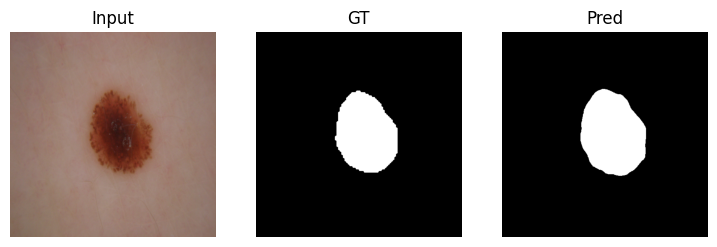

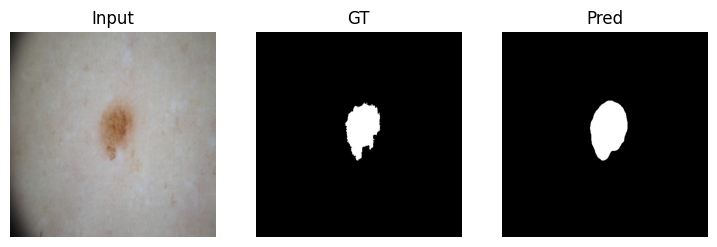

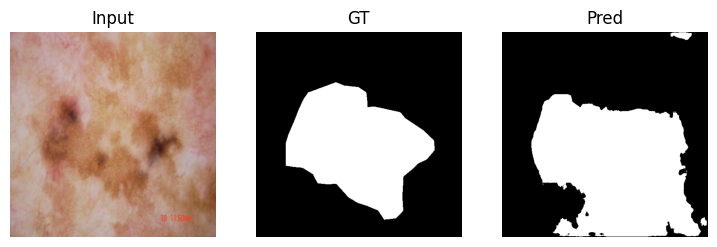

In [ ]:
# 12.4 Visualize a few test predictions
import matplotlib.pyplot as plt
import random

# pick 3 random indices
idxs = random.sample(range(len(all_preds)), 3)
for idx in idxs:
    img_tensor, _ = test_dataset[idx]
    img_np  = img_tensor.permute(1,2,0).numpy()
    gt_mask = all_targets[idx][0].numpy()
    pr_mask = (all_preds[idx][0] > 0.5).numpy()

    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(img_np);      plt.title("Input"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(gt_mask, cmap='gray'); plt.title("GT");  plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(pr_mask, cmap='gray'); plt.title("Pred");plt.axis('off')
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 2) Imports
import torch
import segmentation_models_pytorch as smp

# 3) Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 4) Rebuild the exact same model architecture
model = smp.Unet(
    encoder_name    = 'resnet34',
    encoder_weights = None,   # or 'imagenet' if you want those pre-trained weights underneath
    in_channels     = 3,
    classes         = 1
).to(device)

# 5) Load your saved weights
CHECKPOINT_PATH = '/content/drive/My Drive/Melanoma Detection/best_unet.pth'
state = torch.load(CHECKPOINT_PATH, map_location=device)
model.load_state_dict(state)

# 6) Switch to eval mode
model.eval()

print("✅ Model loaded and ready on", device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded and ready on cuda


In [ ]:
# 12.5 (Optional) Save predicted masks to disk
out_dir = '/content/drive/My Drive/Melanoma Detection/test_predictions'
os.makedirs(out_dir, exist_ok=True)
for stem, pred in zip(test_stems, all_preds):
    mask_pred = (pred[0].numpy() > 0.5).astype(np.uint8) * 255
    cv2.imwrite(os.path.join(out_dir, f"{stem}_pred.png"), mask_pred)
print("Saved test predictions to:", out_dir)

Saved test predictions to: /content/drive/My Drive/Melanoma Detection/test_predictions


In [ ]:
SAVE_PATH = '/content/drive/My Drive/Melanoma Detection/best_unet.pth'

# 2) Save only the state_dict
torch.save(model.state_dict(), SAVE_PATH)
print(f"Model weights saved to {SAVE_PATH}")

Model weights saved to /content/drive/My Drive/Melanoma Detection/best_unet.pth


## PART-02: MELANOMA SKIN CANCER CLASSIFICATION USING EFFICIENT-NET

In [ ]:
!pip install kaggle --quiet
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aki799","key":"1b244ede237e2deb189f97e0231db330"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir -p /content/data/melanoma
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images -p /content/data/melanoma
!unzip -q /content/data/melanoma/melanoma-skin-cancer-dataset-of-10000-images.zip -d /content/data/melanoma

Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
License(s): CC0-1.0
 89% 88.0M/98.7M [00:00<00:00, 915MB/s]
100% 98.7M/98.7M [00:00<00:00, 919MB/s]


### Classification Dataset Construction with Segmentation-Based Cropping

This cell prepares the data pipeline for the lesion classification task, leveraging the previously trained U-Net segmentation model to automatically localize and crop lesions before classification:

- **Directory Setup:**  
  Points to the benign and malignant image folders for both train and test splits.

- **Preprocessing and Transforms:**  
  Defines two separate preprocessing pipelines:
  - `seg_preprocess`: Resizes and normalizes images for input to the U-Net segmentation model.
  - `cls_transform`: Crops and prepares images (including ImageNet normalization) for input to the EfficientNet classifier.

- **Custom Dataset (`MelanomaSegCropDataset`):**  
  For every image:
  - Loads and preprocesses the image.
  - Uses the trained U-Net to generate a lesion mask.
  - Crops the image to the bounding box of the detected lesion (or a default crop if the mask fails).
  - Applies final transforms and returns the cropped region and its class label (benign or malignant).

- **Data Splitting and DataLoaders:**  
  - Splits the data into stratified training and validation subsets to ensure balanced class distribution.
  - Creates DataLoader objects for train, validation, and test sets for efficient batch processing.

- **Sanity Check:**  
  - Prints the batch shapes for all splits to confirm correct pipeline operation.

This approach ensures that the classification model receives focused lesion crops, enhancing its ability to learn relevant diagnostic features.

In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split

# ─── 1) Define your directories ─────────────────────────────────────────────────
base_dir    = '/content/data/melanoma/melanoma_cancer_dataset'
train_root  = os.path.join(base_dir, 'train')
test_root   = os.path.join(base_dir, 'test')

# ─── 2) Transforms ──────────────────────────────────────────────────────────────
seg_preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])
cls_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ─── 3) Dataset applying your trained UNet to crop lesions ───────────────────────
class MelanomaSegCropDataset(Dataset):
    def __init__(self, root_dir, seg_model, seg_preprocess, cls_transform):
        """
        root_dir/
          benign/
          malignant/
        """
        self.samples = []
        for cls_name, label in [('benign',0), ('malignant',1)]:
            folder = os.path.join(root_dir, cls_name)
            for fname in os.listdir(folder):
                if fname.lower().endswith(('.jpg','.png')):
                    self.samples.append((os.path.join(folder, fname), label))
        self.seg_model      = seg_model.eval()
        self.seg_preprocess = seg_preprocess
        self.cls_transform  = cls_transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        # load & convert
        img_bgr = cv2.imread(path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        # segment
        x = self.seg_preprocess(img_rgb).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = self.seg_model(x)
            mask = (torch.sigmoid(logits)[0,0].cpu().numpy() > 0.5).astype(np.uint8)
        # crop bbox
        ys, xs = np.where(mask)
        if len(ys)==0 or len(xs)==0:
            h, w, _ = img_rgb.shape
            y1, y2 = h//4, 3*h//4
            x1, x2 = w//4, 3*w//4
        else:
            y1, y2 = ys.min(), ys.max()
            x1, x2 = xs.min(), xs.max()
        crop = img_rgb[y1:y2, x1:x2]
        # classification transform
        crop = self.cls_transform(crop)
        return crop, label

# ─── 4) Instantiate & split train/val ──────────────────────────────────────────
full_train_ds = MelanomaSegCropDataset(train_root, model, seg_preprocess, cls_transform)
idxs = np.arange(len(full_train_ds))
labels = [lbl for _, lbl in full_train_ds.samples]
train_idx, val_idx = train_test_split(
    idxs, test_size=0.2, stratify=labels, random_state=42
)
train_ds = Subset(full_train_ds, train_idx)
val_ds   = Subset(full_train_ds, val_idx)

# ─── 5) Instantiate test dataset ───────────────────────────────────────────────
test_ds = MelanomaSegCropDataset(test_root, model, seg_preprocess, cls_transform)

# ─── 6) DataLoaders ────────────────────────────────────────────────────────────
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                          num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=0, pin_memory=True)

# ─── 7) Sanity check ───────────────────────────────────────────────────────────
for name, loader in [('Train', train_loader), ('Val', val_loader), ('Test', test_loader)]:
    imgs, lbls = next(iter(loader))
    print(f"{name} batch shapes: imgs {imgs.shape}, labels {lbls.shape}")


Train batch shapes: imgs torch.Size([32, 3, 224, 224]), labels torch.Size([32])
Val batch shapes: imgs torch.Size([32, 3, 224, 224]), labels torch.Size([32])
Test batch shapes: imgs torch.Size([32, 3, 224, 224]), labels torch.Size([32])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torchvision.models import efficientnet_b0

# ─── 8) Build the classifier ───────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

cls_model = efficientnet_b0(pretrained=True)
# Replace final layer for 2 classes: benign (0), malignant (1)
cls_model.classifier[1] = nn.Linear(
    cls_model.classifier[1].in_features,
    2
)
cls_model = cls_model.to(device)

# ─── 9) Loss, optimizer, (optional) scheduler ─────────────────────────────────
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cls_model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

# ─── 10) Training & validation loop ────────────────────────────────────────────
num_epochs     = 20
best_val_acc   = 0.0
early_stop_pat = 5
no_improve     = 0

for epoch in range(1, num_epochs+1):
    # — Train —
    cls_model.train()
    running_loss, running_corrects = 0.0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cls_model(imgs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss     += loss.item() * imgs.size(0)
        running_corrects += (outputs.argmax(1)==labels).sum().item()
    train_loss = running_loss / len(train_ds)
    train_acc  = running_corrects / len(train_ds)

    # — Validate —
    cls_model.eval()
    val_corrects = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = cls_model(imgs)
            val_corrects += (outputs.argmax(1)==labels).sum().item()
    val_acc = val_corrects / len(val_ds)

    # — Scheduler & checkpoint —
    scheduler.step(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve   = 0
        torch.save(cls_model.state_dict(), 'best_classifier.pth')
        ckpt = '✓'
    else:
        no_improve += 1
        ckpt = ''

    print(
        f"Epoch {epoch}/{num_epochs} • "
        f"Train Loss: {train_loss:.4f} • Train Acc: {train_acc:.4f} • "
        f"Val Acc: {val_acc:.4f} {ckpt} • "
        f"No Improve: {no_improve}/{early_stop_pat}"
    )

    if no_improve >= early_stop_pat:
        print("Early stopping triggered.")
        break

# ─── 11) Test-set evaluation ───────────────────────────────────────────────────
cls_model.load_state_dict(torch.load('best_classifier.pth', map_location=device))
cls_model.eval()
test_corrects = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = cls_model(imgs)
        test_corrects += (outputs.argmax(1)==labels).sum().item()
test_acc = test_corrects / len(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


Using device: cuda


100%|██████████| 20.5M/20.5M [00:00<00:00, 142MB/s]


Epoch 1 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 1/20 • Train Loss: 0.2968 • Train Acc: 0.8773 • Val Acc: 0.9276 ✓ • No Improve: 0/5


Epoch 2 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 2/20 • Train Loss: 0.1734 • Train Acc: 0.9313 • Val Acc: 0.9318 ✓ • No Improve: 0/5


Epoch 3 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 3/20 • Train Loss: 0.1428 • Train Acc: 0.9439 • Val Acc: 0.9266  • No Improve: 1/5


Epoch 4 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 4/20 • Train Loss: 0.0968 • Train Acc: 0.9636 • Val Acc: 0.9323 ✓ • No Improve: 0/5


Epoch 5 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 5/20 • Train Loss: 0.0716 • Train Acc: 0.9758 • Val Acc: 0.9297  • No Improve: 1/5


Epoch 6 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 6/20 • Train Loss: 0.0475 • Train Acc: 0.9831 • Val Acc: 0.9318  • No Improve: 2/5


Epoch 7 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 7/20 • Train Loss: 0.0374 • Train Acc: 0.9852 • Val Acc: 0.9256  • No Improve: 3/5


Epoch 8 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 8/20 • Train Loss: 0.0365 • Train Acc: 0.9863 • Val Acc: 0.9313  • No Improve: 4/5


Epoch 9 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 9/20 • Train Loss: 0.0250 • Train Acc: 0.9922 • Val Acc: 0.9339 ✓ • No Improve: 0/5


Epoch 10 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 10/20 • Train Loss: 0.0188 • Train Acc: 0.9947 • Val Acc: 0.9308  • No Improve: 1/5


Epoch 11 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 11/20 • Train Loss: 0.0186 • Train Acc: 0.9952 • Val Acc: 0.9308  • No Improve: 2/5


Epoch 12 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 12/20 • Train Loss: 0.0168 • Train Acc: 0.9947 • Val Acc: 0.9271  • No Improve: 3/5


Epoch 13 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 13/20 • Train Loss: 0.0172 • Train Acc: 0.9941 • Val Acc: 0.9360 ✓ • No Improve: 0/5


Epoch 14 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 14/20 • Train Loss: 0.0153 • Train Acc: 0.9956 • Val Acc: 0.9318  • No Improve: 1/5


Epoch 15 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 15/20 • Train Loss: 0.0137 • Train Acc: 0.9957 • Val Acc: 0.9292  • No Improve: 2/5


Epoch 16 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 16/20 • Train Loss: 0.0140 • Train Acc: 0.9960 • Val Acc: 0.9328  • No Improve: 3/5


Epoch 17 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 17/20 • Train Loss: 0.0158 • Train Acc: 0.9956 • Val Acc: 0.9287  • No Improve: 4/5


Epoch 18 [Train]:   0%|          | 0/241 [00:00<?, ?it/s]

Epoch 18/20 • Train Loss: 0.0128 • Train Acc: 0.9966 • Val Acc: 0.9302  • No Improve: 5/5
Early stopping triggered.
Test Accuracy: 0.9150


In [ ]:
# 1) Mount Google Drive (if not already)
from google.colab import drive
drive.mount('/content/drive')

# 2) Define save path in your Drive
SAVE_DIR  = '/content/drive/My Drive/Melanoma Detection'
os.makedirs(SAVE_DIR, exist_ok=True)
SAVE_PATH = os.path.join(SAVE_DIR, 'best_classifier.pth')

# 3) Save only the state_dict of your classifier
torch.save(cls_model.state_dict(), SAVE_PATH)
print(f"Classifier weights saved to: {SAVE_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classifier weights saved to: /content/drive/My Drive/Melanoma Detection/best_classifier.pth


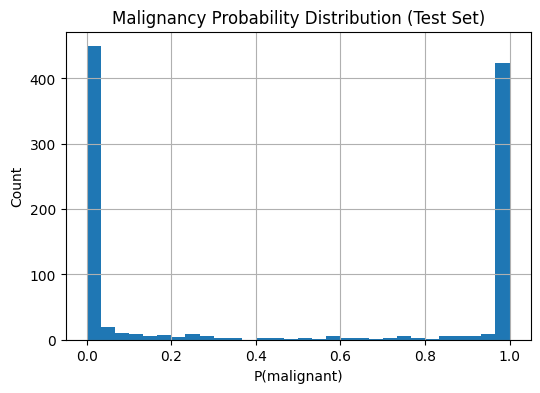

Top 10 most serious lesions:
                 p_malignant
stem                       
melanoma_10223          1.0
melanoma_10449          1.0
melanoma_10166          1.0
melanoma_10422          1.0
melanoma_10467          1.0
melanoma_10206          1.0
melanoma_10477          1.0
melanoma_10420          1.0
melanoma_10280          1.0
melanoma_10466          1.0
449 lesions with P(malignant) > 0.8


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Gather the stems in test order directly from test_ds.samples
#    (test_loader was created with shuffle=False)
stems = [os.path.splitext(os.path.basename(path))[0]
         for path, _ in test_ds.samples]

# 2) Run classifier to get P(malignant) for each test crop
cls_model.eval()
all_probs = []
with torch.no_grad():
    for imgs, _ in test_loader:
        imgs = imgs.to(device)
        logits = cls_model(imgs)
        probs  = torch.softmax(logits, 1)[:,1].cpu().numpy()   # malignant class
        all_probs.append(probs)
all_probs = np.concatenate(all_probs)  # shape = (N_test,)

# 3) Build DataFrame
df_scores = pd.DataFrame({
    'stem':        stems,
    'p_malignant': all_probs
}).set_index('stem')

# 4) Visualize distribution
plt.figure(figsize=(6,4))
df_scores['p_malignant'].hist(bins=30)
plt.title("Malignancy Probability Distribution (Test Set)")
plt.xlabel("P(malignant)")
plt.ylabel("Count")
plt.show()

# 5) Top-10 most serious lesions
top10 = df_scores.sort_values('p_malignant', ascending=False).head(10)
print("Top 10 most serious lesions:\n", top10)

# 6) High-risk set (e.g. P > 0.8)
high_risk = df_scores[df_scores['p_malignant'] > 0.8]
print(f"{len(high_risk)} lesions with P(malignant) > 0.8")


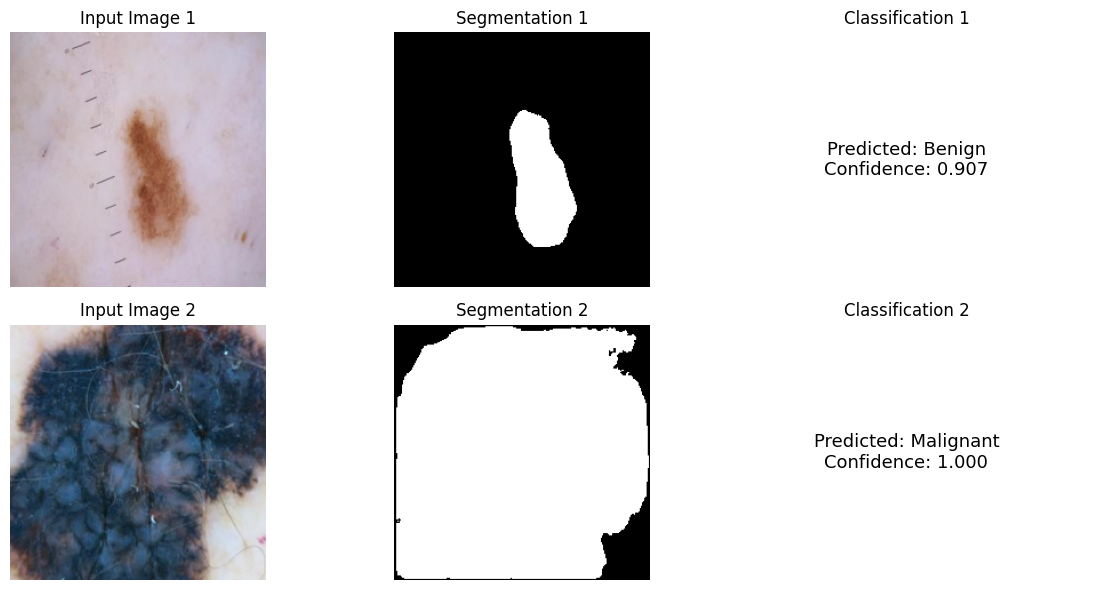

In [28]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Set your two image paths
img_path_01 = '/content/data/melanoma/melanoma_cancer_dataset/test/benign/melanoma_10088.jpg'
img_path_02 = '/content/data/melanoma/melanoma_cancer_dataset/test/malignant/melanoma_10190.jpg'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_names = ['Benign', 'Malignant']

def run_all(img_path):
    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224), interpolation=cv2.INTER_AREA)
    img_norm = img_resized.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img_norm).permute(2,0,1).unsqueeze(0).float().to(device)

    # --- Segmentation prediction ---
    model.eval()
    with torch.no_grad():
        seg_pred = model(img_tensor)
        seg_prob = torch.sigmoid(seg_pred[0, 0]).cpu().numpy()
        seg_mask = (seg_prob > 0.5)

    # --- Classification prediction ---
    cls_model.eval()
    with torch.no_grad():
        img_tensor_cls = (img_tensor - img_tensor.mean()) / (img_tensor.std() + 1e-7)
        cls_pred = cls_model(img_tensor_cls)
        cls_prob = torch.softmax(cls_pred, dim=1).cpu().numpy()[0]
        cls_label_idx = cls_prob.argmax()
        cls_label = class_names[cls_label_idx]
        cls_conf = cls_prob[cls_label_idx]

    # Prepare image for display
    img_disp = img_resized / 255.0

    return img_disp, seg_mask, cls_label, cls_conf

# Run predictions
img1, seg1, label1, conf1 = run_all(img_path_01)
img2, seg2, label2, conf2 = run_all(img_path_02)

# Plot
plt.figure(figsize=(12, 6))
for i, (img, seg, label, conf) in enumerate([(img1, seg1, label1, conf1), (img2, seg2, label2, conf2)]):
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Input Image {i+1}')
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(seg, cmap='gray')
    plt.axis('off')
    plt.title(f'Segmentation {i+1}')
    plt.subplot(2, 3, i*3 + 3)
    plt.text(0.5, 0.5, f'Predicted: {label}\nConfidence: {conf:.3f}',
             ha='center', va='center', fontsize=13)
    plt.axis('off')
    plt.title(f'Classification {i+1}')
plt.tight_layout()
plt.show()

THANK YOU!